In [80]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt
import pickle
from dataclasses import dataclass

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

# Stock Price Prediction Using Machine Learning Models

by Andon Gorchov (@thunderman913)

## Abstract

This project aims to build machine learning models, which are good at predicting stock prices, based on stock and financial data. Various models will be explored, including Support Vector Regression (SVR), K-Nearest Neighbors (KNN), Random Forest Regressors (RFR) and Linear Regression The analysis uses historical stock data, which includes factors such as the value of a stock, trade volume and economic indicators. In order to train and evaluate this model, the dataset is pre-processed and analyzed under appropriate conditions, so that the model can be run. Apart from the data, hyperparameter tuning is performed using GridSearchCV to find the optimal parameters for each algorithm. The performance of the models is evaluated using Mean Squared Error (MSE) to compare their accuracy in predicting stock closing prices. The findings provide insights into the effectiveness of different machine learning techniques for stock price forecasting, highlighting the strengths and limitations of each approach in dealing with financial market data.

## 1. Problem Definition

Trying to predict the stock market price is a century old task, that no one has yet perfected. The big corporations and hedge funds put their best effort to outsmart the normal traders, but still they sometimes fail. There has not been a perfect tool for predicting the price and if one comes out at any point, it will for sure disrupt the market. The project's main goal is to create machine learning models, that are sufficient in predicting the price of a stock. Two different datasets will be used to achieve this goal - stock price data and earnings data. Everything will be preprocessed, so that the models can be run on it and hopefully predict close to the actual data. 4 different models will be explored and experimented with, so we can see, which one performs best in our circumstances. The hyperparameters will be tuned as much as possible, but since the dataset has 27 different features and nearly 7 million rows - the task to perfect the model will be difficult. In no means, I am expecting the models to predict accurately to the actual price, but I do expected, that some models work much better than others.

## 2. Data analysis and tidying

We will need some stock datasets and the perfect one for this task is this one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price informations for more than 7000 tickers. Also it has earnings data for the different stock. Some are quarterly, others are yearly, but we will figure out how to use them. First lets define some methods, that will be used for reading the data.

In order not to download the dataset locally, we can read it from the remote using those paths.

Pickles will be used for most of the data processed/machine learning models, because those are slow operations and it is better for us, not to perform them every time.

In [2]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

earnings_data_path = './pickles/earnings_data_processed.pkl'
stock_data_path = './pickles/stock_data_processed.pkl'

In [3]:
# Calculate the peak price over a rolling window and days since the peak price
def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

# Adds features like prices and volumes for specific days ago for each stock (ticker)
# and calculates the peak price and days since the peak price
def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    return df

In [4]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    # Remove NA earnings dates
    merged_df = merged_df.drop(merged_df[(merged_df.earnings_date.isna()) | (merged_df.earnings_date_next.isna())].index)
    merged_df['days_till_report'] = (merged_df['earnings_date_next'] - merged_df['date']).dt.days
    merged_df['days_since_report'] = (merged_df['date'] - merged_df['earnings_date']).dt.days

    return merged_df

In [5]:
# Read and tidy the earnings data dataset
def getEarningsData():

    if os.path.exists(earnings_data_path):
        return pd.read_pickle(earnings_data_path)

    earnings_data = pd.read_csv(earnings_path)

    earnings_data_tidy = earnings_data
    earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

    earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

    earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
    earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

    earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

    earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

    earnings_data_tidy.to_pickle(earnings_data_path)

    return earnings_data_tidy

In [6]:
# Read and tidy the stock data dataset
def getTidiedStockData():
    # Check if the file exists
    if os.path.exists(stock_data_path):
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    earnings_data_tidy = getEarningsData()

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['earnings_date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['earnings_date'].max() + pd.Timedelta(days=5))]

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    
    stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])
    
    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [7]:
stock_data_tidy = getTidiedStockData()

After everything writte above, we can just call the above method and get all of the data needed for the machine learning.

In [8]:
stock_data_tidy

,ticker,date,open,high,low,close,close_adjusted,volume,price_1_days_ago,volume_1_days_ago,...,peak_price,peak_days_ago,earnings_date,eps_est,eps,release_time,earnings_date_next,days_till_report,days_since_report,ticker_encoded
11137135,C,2012-07-16,27.4500,27.5300,26.6200,26.8100,26.0433,59427600,26.6500,48422100.0,...,38.08,81,2012-07-16,0.88,0.95,pre,2012-10-15,91,0,718
11138878,CSX,2012-07-17,22.7300,22.8600,22.2800,22.7900,20.1997,7041400,22.5900,4914000.0,...,22.79,0,2012-07-17,0.47,0.49,post,2012-10-16,91,0,1105
11138900,FIS,2012-07-17,34.3200,34.5200,34.1300,34.2300,31.2043,1177000,34.3000,1234200.0,...,34.80,9,2012-07-17,0.60,0.66,post,2012-11-05,111,0,1605
11139425,WYNN,2012-07-17,97.4500,98.2700,95.5801,97.3600,96.6684,2317100,96.4400,2089100.0,...,135.04,55,2012-07-17,1.48,1.38,post,2012-10-24,99,0,4548
11140712,C,2012-07-17,27.1300,27.4100,26.6100,27.3800,26.5970,39561100,26.8100,59427600.0,...,38.08,82,2012-07-16,0.88,0.95,pre,2012-10-15,90,1,718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,0.5285,0.5477,0.5100,0.5244,0.5244,5190814,0.5233,10176718.0,...,1.41,79,2020-09-10,-0.15,-0.09,post,2021-06-14,4,273,81
23692035,RFIL,2021-06-10,8.0000,8.0000,7.9100,7.9600,7.9600,26264,7.9300,14128.0,...,7.98,5,2021-03-11,0.03,-0.03,pre,2021-06-14,4,91,3506
23693010,ADXS,2021-06-11,0.5173,0.5379,0.5060,0.5156,0.5156,4467153,0.5244,5190814.0,...,1.41,80,2020-09-10,-0.15,-0.09,post,2021-06-14,3,274,81
23693122,RFIL,2021-06-11,7.9700,8.0200,7.8000,7.8000,7.8000,78435,7.9600,26264.0,...,7.98,6,2021-03-11,0.03,-0.03,pre,2021-06-14,3,92,3506


We can see the features it has - ticker, prices and volumes for each day, latest earnings, days since and till next report and also the peak price.

The earnings have been added to the actual data, but with a different frequence and this is the reason why, the columns days_till_report and days_since_report are introduces. Every single row has the latest earnings. For example if the earnings are 5 days ago, we fill those. If the earnings happened today we fill them. If they happened 70 days ago, we fill them with the latest ones. Having the days to and since the next report will help our model understand this.

In [9]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
11137135,C,2012-07-16,2012-07-16,2012-10-15,91,0
11138878,CSX,2012-07-17,2012-07-17,2012-10-16,91,0
11138900,FIS,2012-07-17,2012-07-17,2012-11-05,111,0
11139425,WYNN,2012-07-17,2012-07-17,2012-10-24,99,0
11140712,C,2012-07-17,2012-07-16,2012-10-15,90,1
...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,2020-09-10,2021-06-14,4,273
23692035,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
23693010,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
23693122,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case. We want the model to be able to predict data, when it has enough information about it.

We also remove some columns, that are not used in the trainings:

open, high, low, close_adjusted and volume - those are features, that are about our current day, that we want to predict. For the previous days for the most part, we shouldn't care, what those are, since we are gonna have the close price.

In [10]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)
# Remove useless columns
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [11]:
stock_data_tidy.shape[0]

6713717

In [12]:
stock_data_tidy.ticker.unique().shape[0]

4640

We can see, that we have 6.7 million rows of data with 4640 different stocks being tracked. That should be pretty much enough data for our task.

## 3. Model Training

Now that, the data is prepared and tidied, we can continue with the model training. Let's first define some variables and methods.

In [13]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

target = 'close'

Those are all the features we will use througout the different models. Our target will obviously be the close price.

In [14]:
@dataclass
class PreparedData:
    X_train: any
    X_test: any
    y_train: any
    y_test: any
    scaler_X: any = None
    scaler_y: any = None

# Function to prepare the data for model training and evaluation
# This function scales features and target, and splits the dataset into training, testing, and final test sets
def prepare_data(data, features, target, scale_output, frac=0.05):
    stock_data_tidy_train = data.sample(frac=frac, random_state=42)
    
    X = stock_data_tidy_train[features]
    y = stock_data_tidy_train[target]

    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    
    if scale_output:    
        scaler_y = StandardScaler()
        y = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
    else:
        scaler_X, scaler_y = None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return PreparedData(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        scaler_X=scaler_X,
        scaler_y=scaler_y
    )

We will use the "prepare_data" function to prepare the data for the training. It does all the work - scales the data where necessary and splits it into train, test and final test sets. The final test set is kept completely separate from the training data, to provide an unbiased evaluation of the model's performance on new, unseen data. This is particularly important for stock data, where overfitting is a risk due to the complexity and volatility of financial markets.

Also let's initialize all the pickle paths we will use for the different models.

In [182]:
forest_grid_search_path = './pickles/forest_grid_search.pkl'
svr_grid_search_path = './pickles/svr_grid_search.pkl'
linear_svr_grid_search_path = './pickles/libear_svr_grid_search.pkl'
knn_grid_search_path = './pickles/knn_grid_search.pkl'

svr_model_path = './pickles/svr_model.pkl'
forest_model_path = './pickles/forest_model.pkl'

forest_mse_plots_path = './pickles/forest_mse_plots.pkl'
checkpoint_file = "./pickles/random_forest_checkpoint.pkl"
chunk_index_file = "./pickles/random_forest_chunk_index.pkl"
knn_y_pred_file = './pickles/y_pred_knn.pkl'

And finally we need a method for model evalutation:a

In [133]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a given model using test data and calculates key metrics.

    Parameters:
        model: The trained model to evaluate.
        X_test: Test features.
        y_test: Test target values.

    Returns:
        A dictionary containing the calculated metrics.
    """
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics
    print(f"Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")

### 3.1. Random Forest Regressor

Let's begin with the GridSearch, in order to get the best hyperparams.

We get 1% of the data, in order to do the calculations for it. It is around 53k rows of data, which should be pretty much enough for our case. Having more would be better, but the time it takes grows very much.

In [81]:
forest_grid_search_data = prepare_data(stock_data_tidy, features, target, False, 0.01)

In [18]:
def getGridSearch():
    if os.path.exists(forest_grid_search_path):
        return pd.read_pickle(forest_grid_search_path)

    param_grid = {
        'n_estimators': [1, 50, 100, 200, 300],
        'max_depth': [5, 10, 20, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    forest_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, n_jobs=-1)
    forest_grid_search.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)

    best_params = forest_grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    with open(forest_grid_search_path, 'wb') as model_file:
        pickle.dump(forest_grid_search, model_file)

    return forest_grid_search

In [19]:
forest_grid_search = getGridSearch()

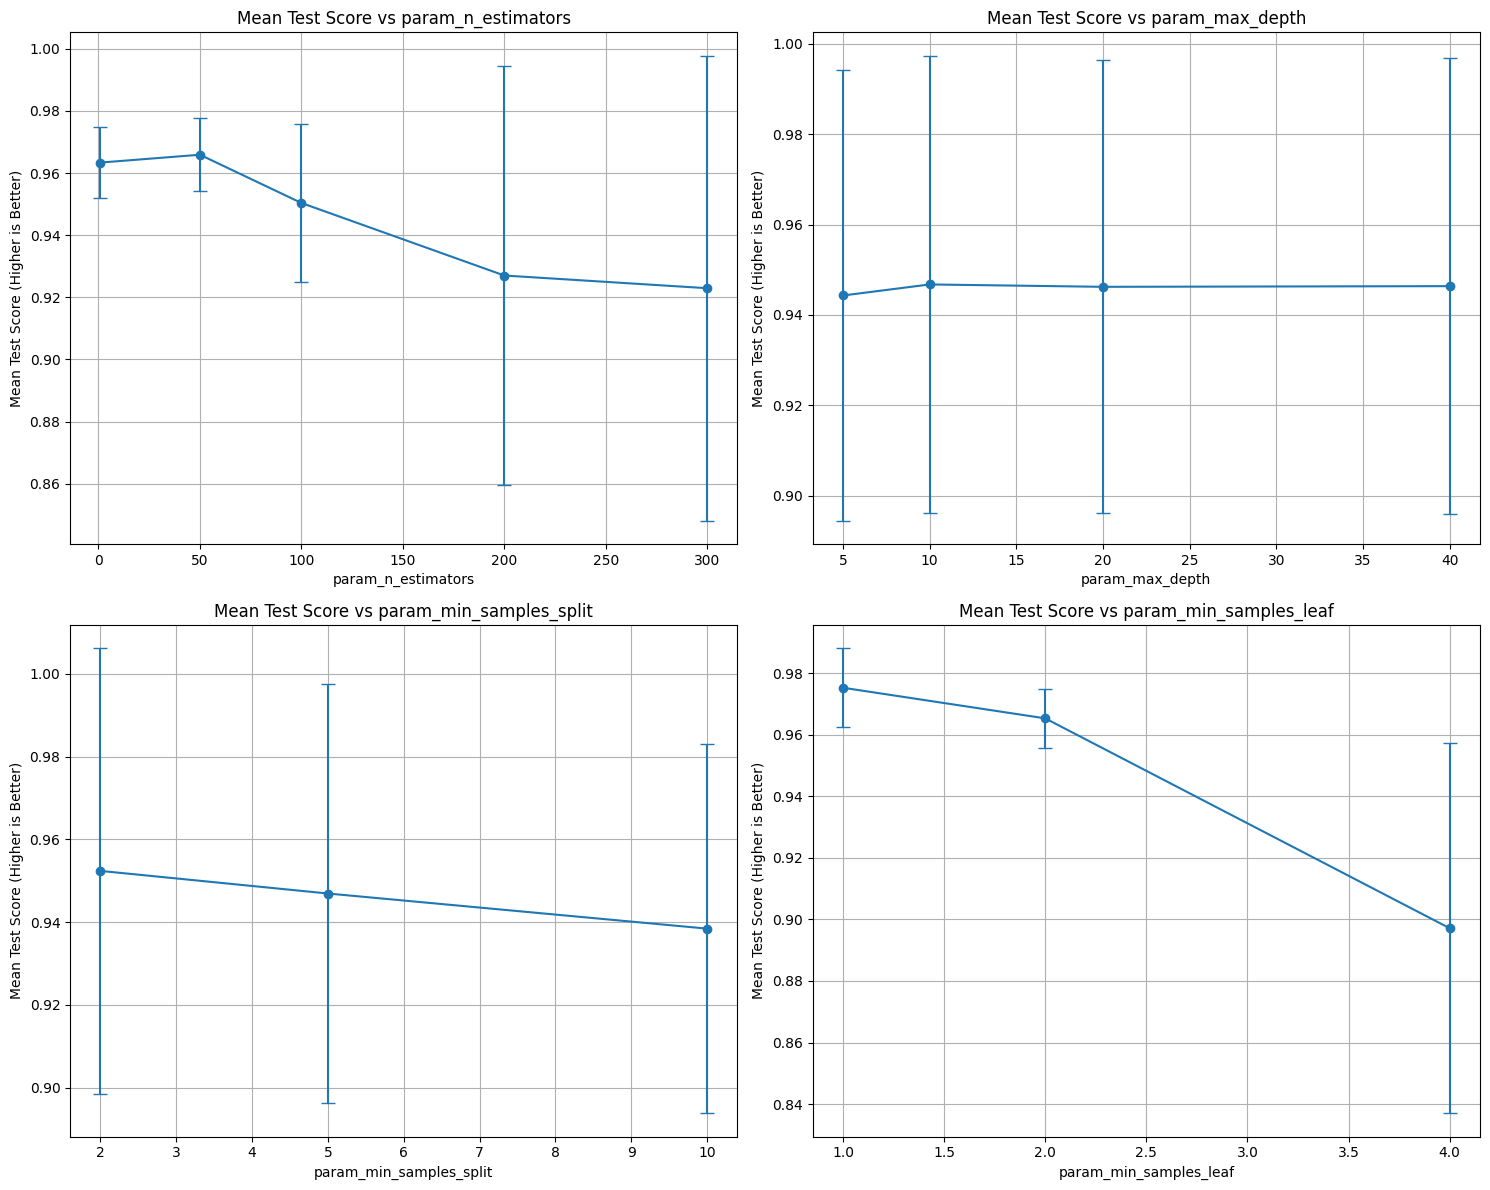

In [20]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
cv_results = pd.DataFrame(forest_grid_search.cv_results_)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs = axs.flatten()

for i, param in enumerate(params):
    mean_test_scores = cv_results.groupby(param)['mean_test_score'].mean()
    std_test_scores = cv_results.groupby(param)['mean_test_score'].std()
    
    # Plotting the mean test score with error bars representing the standard deviation
    axs[i].errorbar(mean_test_scores.index, mean_test_scores, yerr=std_test_scores, fmt='o-', capsize=5, capthick=1)
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('Mean Test Score (Higher is Better)')
    axs[i].set_title(f'Mean Test Score vs {param}')
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [21]:
forest_grid_search.best_params_

{'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Now that we have all the data visualized, we can choose our hyperparams correctly.

The ones from the GridSearch are:

{'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Max depth specifies the maximum depth of each tree in the forest. Usually the deeper it is, the higher risk there is for overfitting. On the other side shallower trees might underfit. In our case, we can see, that the max depth doesn't change much the accuracy of our model. The grid search suggests, that we use 40, so we will keep to that, as we cannot see much of a difference.

Min sample leaf defines the minimum number of samples required in a leaf node. When the value is 1, the model might overfit, so we will monitor for overfitting and if we get results close to 100, then we should increase this value. We can see from the charts above, that 1 is by far the best value for our data, the accuracy of the rest is falling significantly.

Min sample splits is the number of samples to split a node. Generally low values tend to overfit the model, but 2 is a good value to start with and see, what the accuracy will be. 2 is also the default setting for the random forest regressor, so using it is usually the go to value and since we can obviously see from the charts, that it is much better than higher values, we will go with it and monitor the model for overfitting.

N estimators is the number of trees in the forest. More trees improve model stability and performance, but increase computation cost. We will begin with 50, since this is the suggestion from the grid search. Our way of fitting the model is by incrementally fitting the data, since the dataset is huge and fitting it all at once will be very slow and 50 is the go-to value for only 1% of the data. When incrementally fitting the model, we will add 10 estimators for each chunk of 10 000.

Now let's create the data, to which we will train our model. We want to use all the 6.7 mil rows, so we prepare the data that way.

In [129]:
forest_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

Then we fit the data, using the best hyperparams we figured out. Again this is gonna be a slow process, so we use a pickle for it.

I tried fitting the model locally and it took 2 hours and got nowhere, so I managed to fit it using google colab's processing units in under 1 hour.

We incrementally fit the model using the warm_start option. Our chunks are 10 000 each and we add 10 estimators per chunk, which should be good enough value for such added data. Later we will experiment with 10 000 chunk size and adding 50 estimators each time, which will get much slower fitting time.

At first we check, if we have already have a checkpoint or fitted the model itself. If we already have a pickle of the model, then we just load it and don't do the whole fitting part. Otherwise we load the checkpoint and continue from it.

In [83]:
chunk_size = 10000
save_interval = 10

# Load or initialize model
if os.path.exists(forest_model_path):
    with open(forest_model_path, 'rb') as f:
        forest_model = pickle.load(f)
        print("Loaded model from pickle.")
else:
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            forest_model = pickle.load(f)
        print("Loaded model from checkpoint.")
        with open(chunk_index_file, 'rb') as f:
            start_chunk = pickle.load(f)
        print(f"Loaded model from checkpoint. Resuming from chunk {start_chunk}.")
    else:
        forest_model = RandomForestRegressor(
            max_depth=40,
            min_samples_leaf=1,
            min_samples_split=2,
            n_estimators=50,
            warm_start=True,
            random_state=42)
        start_chunk = 0
        
    for i, chunk_start in enumerate(range(start_chunk * chunk_size, len(forest_model_data.X_train), chunk_size), start=start_chunk):
        print(f"Fitting {i} chunk, {len(forest_model_data.X_train) - (chunk_start + chunk_size)} rows left")
        X_chunk = forest_model_data.X_train[chunk_start:chunk_start + chunk_size]
        y_chunk = forest_model_data.y_train[chunk_start:chunk_start + chunk_size]

        if i > 0:
            forest_model.n_estimators += 10 
        forest_model.fit(X_chunk, y_chunk)

        if (i + 1) % save_interval == 0 or (chunk_start + chunk_size) >= len(forest_model_data.X_train):
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(forest_model, f)
            with open(chunk_index_file, 'wb') as f:
                pickle.dump(i + 1, f)
            print(f"Saved model checkpoint at iteration {i + 1}")

    with open(forest_model_path, 'wb') as f:
        pickle.dump(forest_model, f)
    print("Training complete. Final model saved.")

Loaded model from pickle.


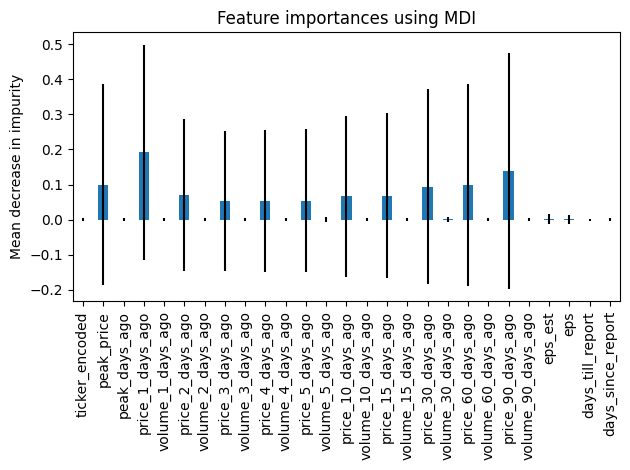

In [19]:
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in features]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

After completing the training, we can view the importance of the features. Some of them are highly biased, while others not so much. We can see, that the volume does not really matter in predicting the stock price. Also the financial data is a bit influencial, but more or less useless. The most important data is about the peak price and the prices beforehand.

In [48]:
evaluate_model(forest_model, forest_model_data.X_test, forest_model_data.y_test)

Random Forest Evaluation Metrics:
Mean Absolute Error (MAE): 11.032912854799893
Mean Squared Error (MSE): 781377.2959258734
Root Mean Squared Error (RMSE): 883.9554830000623
R² Score: 0.883348040671538


Based on the evaluation of the model, there seems to be room for improvement, although the model seems to be good. The MAE and MSE show, that when given larger values, the model does very poor, since the average error is high. That may be due to the fact, that the dataset has a lot more small values, than big ones. Let's try removing from the test set all the values with close > 100 and examine the results.

In [130]:
indices_to_remove = np.where(forest_model_data.y_test > 100)[0]

forest_model_data.X_test = np.delete(forest_model_data.X_test, indices_to_remove, axis=0)
forest_model_data.y_test = np.delete(forest_model_data.y_test, indices_to_remove, axis=0)

In [117]:
evaluate_model(forest_model, forest_model_data.X_test, forest_model_data.y_test)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.43394283488460966
Mean Squared Error (MSE): 1.3863263051116965
Root Mean Squared Error (RMSE): 1.1774235878016444
R² Score: 0.9975748397225477


{'MAE': np.float64(0.43394283488460966),
 'MSE': np.float64(1.3863263051116965),
 'RMSE': np.float64(1.1774235878016444),
 'R2': 0.9975748397225477}

Seems like in lower values the model is actually good and predicts close to the actual values. There are some concerns of overfitting though, since the R squared is very close to 1. So I would assume the model overfitted the smaller data, but when it tries to predict larger ones, it still does pretty good.

## 3.2. Linear Regression

The second model we will look into is linear regression. Here we don't need any hyperparam tuning, so we just prepare the data for the model and perform the machine learning.

The fitting of this algorithm is very fast, takes just 5 seconds.

In [152]:
def plot_feature_coefficients(linear_model):
    """
    Plots the feature coefficients of a Linear regression model.
    
    Parameters:
    ridge_model: Trained Linear regression model.
    """
    coefficients = pd.Series(linear_model.coef_, index=features).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    coefficients.plot(kind='bar')
    plt.title('Feature Coefficients')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()


In [70]:
linear_regression_data = prepare_data(stock_data_tidy, features, target, False, 1)

Training Score: 0.9999208876303298
Mean Squared Error: 529.9234564341557


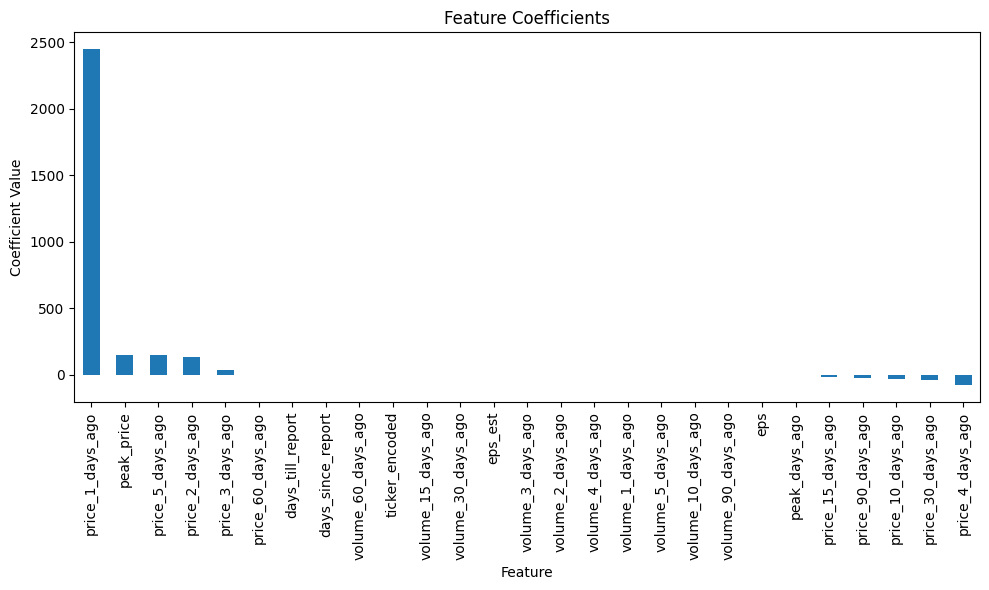

In [154]:
linear_model = LinearRegression()
linear_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

# Score the model on the training data
train_score = linear_model.score(linear_regression_data.X_test, linear_regression_data.y_test)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = linear_model.predict(linear_regression_data.X_test)

# Calculate and print the mean squared error
mse = np.mean((linear_regression_data.y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

plot_feature_coefficients(linear_model)

We can see, that the linear regressions is highly influenced by the price 1 days ago, which is a very close value to the current day close price. They are almost correlated most of the times, since the prices fluxuate only a couple percent per day.

In [155]:
evaluate_model(linear_model, linear_regression_data.X_test, linear_regression_data.y_test)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.9076869690464401
Mean Squared Error (MSE): 529.9234564341557
Root Mean Squared Error (RMSE): 23.020066386397666
R² Score: 0.9999208876303298


The model also seems to overfit the data, let's maybe try to use Ridge regression, since it adds regularization and corrects for overfitting. It adds one more term to the linear regression's cost function, which shrinks the weights of the model to zero or close to zero, in order to make sure the model does not overfit the data.

Let's find the best alpha parameter for the best ridge regression.

In [156]:
ridge = Ridge()
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
ridge_cv = GridSearchCV(ridge, parameters, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(linear_regression_data.X_train, linear_regression_data.y_train)

print(f"Best alpha: {ridge_cv.best_params_['alpha']}")

Best alpha: 1


In [157]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

Ridge(alpha=1)

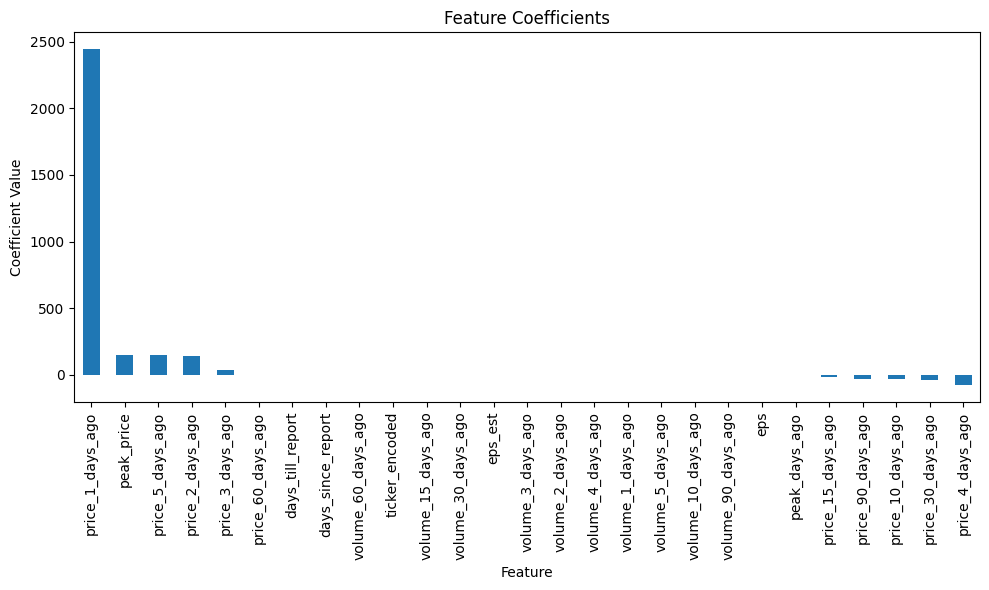

In [158]:
plot_feature_coefficients(ridge_model)

The model is still only influenced by the price_1_days_ago parameter. Let's try increasing the alpha, we want the model to try to predict based on more than one parameter.

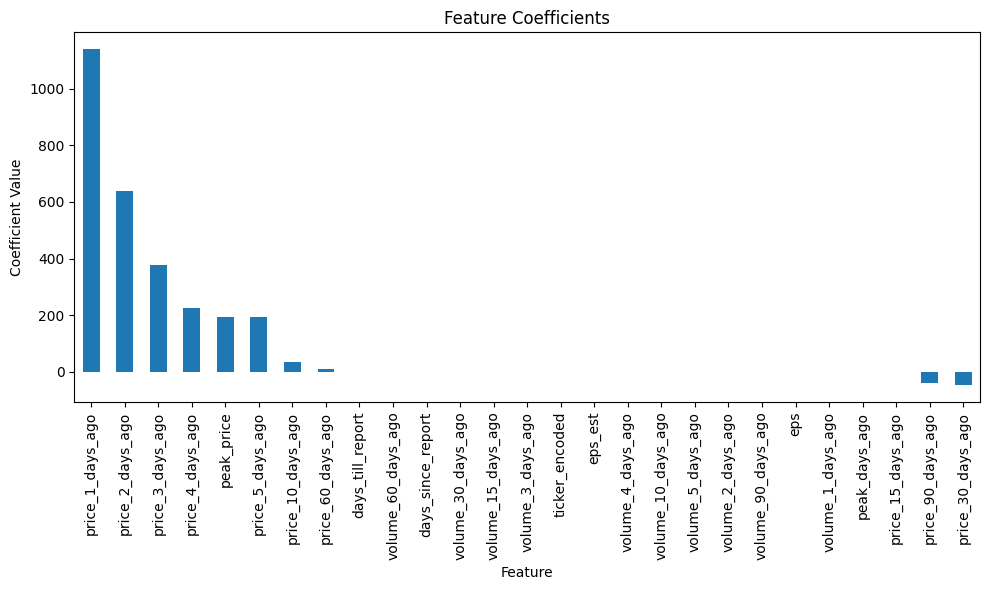

In [170]:
ridge_model = Ridge(alpha=1000)
ridge_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

plot_feature_coefficients(ridge_model)

We will go alpha = 1000, because it uses many different prices. Let's check for the accuracy of the model.

In [171]:
evaluate_model(ridge_model, linear_regression_data.X_test, linear_regression_data.y_test)

Evaluation Metrics:
Mean Absolute Error (MAE): 1.1128326530594337
Mean Squared Error (MSE): 775.0140574052378
Root Mean Squared Error (RMSE): 27.839074291456566
R² Score: 0.9998842980097133


It seems like that, even when the model is not only influenced by only one paramter it is still not good for predictions and overfits the data. This is probably because of the correlations between the different columns, since the price does not change that much.

In conclusion, I believe linear regression models are not suitable for stock data predictions. Maybe if there is a trend line or a chart, that you expect the stock to follow, then it would be a good fit, but for general predictions, not so much.

### 3.3. Support Vector Regression

Next up let's try using Support Vector Regressions for predicting stock prices. The model itself aims to predict continuous values by finding a predefined margin of tolerance. It uses kernel functions to handle non-linear relationships by mapping input features to a higher-dimension space.

As with other models, let's first begin with hyperparameter tuning.

In [37]:
svr_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.005)

In [174]:
def getSvrGridSearch():
    if os.path.exists(svr_grid_search_path):
        return pd.read_pickle(svr_grid_search_path)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly']
    }

    svr = SVR()
    svr_grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    # Best parameters from GridSearchCV
    best_params_svr = svr_grid_search.best_params_
    print(f"Best Parameters for SVR: {best_params_svr}")

    return svr_grid_search

In [175]:
svr_grid_search = getSvrGridSearch()

In [176]:
print(svr_grid_search.best_params_)

{'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}


C (Regularization parameter) controls the trade-off between a low error on the training data and minimizing model complexity. A high value can make the model focus more on minimizing training errors, but it might lead to overfitting. The value of 1 is a moderate one and should keep it balanced.

Epsilon specifies the margin of tolerance, where no penalty is given for errors. When it is a smaller value, it is sensitive to capturing smaller deviations from the true target values and leads to more precise fit, but higher computational cost and might result in overfitting.

Kerner defines the function used to map the input data to a higher-dimensional space for linear or non-linear regression. The one we will use is linear, which means the model assumes a linear relationship between the features and the target variable.

Now, that we got the hyperparams, let's continue with fitting the model.

In [181]:
svr_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

In [ ]:
svr_model = SVR(C=1, epsilon=0.01, kernel='linear', random_state = 42)
svr_model.fit(svr_model_data.X_train, svr_model_data.y_train)

Trying to fit the SVR model, didn't quite work out, since we have a huge dataset and SVR is a very slow algorithm.

In [ ]:
svr_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.005)

In [183]:
from sklearn.svm import LinearSVR

# LinearSVR Grid Search
def getLinearSvrGridSearch():
    if os.path.exists(linear_svr_grid_search_path):
        return pd.read_pickle(linear_svr_grid_search_path)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1]
    }

    linear_svr = LinearSVR(max_iter=10000)  # Increased max_iter for large datasets
    svr_grid_search = GridSearchCV(linear_svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(linear_svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    best_params_svr = svr_grid_search.best_params_
    print(f"Best Parameters for LinearSVR: {best_params_svr}")

    return svr_grid_search


In [184]:
if os.path.exists(linear_svr_grid_search_path):
    svr_grid_search = pd.read_pickle(linear_svr_grid_search_path)
else:
    svr_grid_search = getLinearSvrGridSearch()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for LinearSVR: {'C': 1, 'epsilon': 0.01}


C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TODO investigate linear SVR

### 3.4. K-Nearest Neighbors

TODO write something about KNN

In [26]:
knn_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.05)

In [51]:
def getKnnGridSearch():
    if os.path.exists(knn_grid_search_path):
        return pd.read_pickle(knn_grid_search_path)

    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
    }

    knn = KNeighborsRegressor()
    knn_grid_search = GridSearchCV(knn, param_grid_knn, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    knn_grid_search.fit(knn_grid_search_data.X_train, knn_grid_search_data.y_train)

    with open(knn_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    return svr_grid_search

In [52]:
knn_grid_search = getKnnGridSearch()

# Best parameters from GridSearchCV for KNN
best_params_knn = knn_grid_search.best_params_
print(f"Best Parameters for KNN: {best_params_knn}")

Best Parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [ ]:
knn_data = prepare_data(stock_data_tidy, features, target, True, 1)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 5, p = 1, weights = 'distance')
knn.fit(knn_data.X_train, knn_data.y_train)

KNeighborsRegressor(p=1, weights='distance')

In [ ]:
def predict_in_chunks(model, X_test, scaler_y, chunk_size = 100):
    y_pred_chunks = []
    for start in range(0, len(X_test), chunk_size):
        print('prediction for batch: ', start)
        end = min(start + chunk_size, len(X_test))
        X_chunk = X_test[start:end]
        y_pred_chunk_scaled = model.predict(X_chunk)
        y_pred_chunk = scaler_y.inverse_transform(y_pred_chunk_scaled.reshape(-1, 1)).ravel()
        y_pred_chunks.append(y_pred_chunk)
    return np.concatenate(y_pred_chunks)

if os.path.exists(knn_y_pred_file):
    y_pred_knn = pd.read_pickle(knn_grid_search_path)
else:
    y_pred_knn = predict_in_chunks(knn, knn_grid_search_data.X_test, knn_grid_search_data.scaler_y)
    with open(knn_y_pred_file, 'wb') as model_file:
        pickle.dump(y_pred_knn, model_file)

prediction for batch:  0
prediction for batch:  100
prediction for batch:  200
prediction for batch:  300
prediction for batch:  400
prediction for batch:  500
prediction for batch:  600
prediction for batch:  700
prediction for batch:  800
prediction for batch:  900
prediction for batch:  1000
prediction for batch:  1100
prediction for batch:  1200
prediction for batch:  1300
prediction for batch:  1400
prediction for batch:  1500
prediction for batch:  1600
prediction for batch:  1700
prediction for batch:  1800
prediction for batch:  1900
prediction for batch:  2000
prediction for batch:  2100
prediction for batch:  2200
prediction for batch:  2300
prediction for batch:  2400
prediction for batch:  2500
prediction for batch:  2600
prediction for batch:  2700
prediction for batch:  2800
prediction for batch:  2900
prediction for batch:  3000
prediction for batch:  3100
prediction for batch:  3200
prediction for batch:  3300


KeyboardInterrupt: 

In [38]:
y_true = knn_data.y_test

mae = mean_absolute_error(y_true, y_pred_knn)
mse = mean_squared_error(y_true, y_pred_knn)
rmse = mean_squared_error(y_true, y_pred_knn, squared=False)
r2 = r2_score(y_true, y_pred_knn)
    
print(f"Regression Metrics:\nMAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR²: {r2}")


Regression Metrics:
MAE: 74.32445110041895
MSE: 6679021.6833524285
RMSE: 2584.380328696306
R²: -7386761.651781236


C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 4. Conclusion